# Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

# Load Dataset

In [2]:
df = pd.read_csv("Reviews.csv",index_col=0)

In [3]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Retain only the columns to be used for training
df["review"] = df["Score"].apply(lambda x: 0 if x<4 else 1)
df = df[["Text","review"]]

# Preprocessing

Firstly we will be filtering all the common words like 'a', 'the', 'an' etc. This is achieved by the stop words provided by the nltk library

In [5]:
stop_words = stopwords.words('english')

def filter_stop_words(text):
    text = text.split()
    text = " ".join([word for word in text if word.lower().strip() not in stop_words])
    return text

In [6]:
df["Text"] = df["Text"].apply(lambda x: filter_stop_words(x))
df

,Text,review
Id,,
1,bought several Vitality canned dog food produc...,1
2,Product arrived labeled Jumbo Salted Peanuts.....,0
3,"confection around centuries. light, pillowy ci...",1
4,looking secret ingredient Robitussin believe f...,0
5,Great taffy great price. wide assortment yummy...,1
...,...,...
568450,Great sesame chicken..this good better restura...,1
568451,I'm disappointed flavor. chocolate notes espec...,0
568452,"stars small, give 10-15 one training session. ...",1


### Balancing Training data

The dataset has almost 4 times the positive reviews compared to negative reviews. To counter this we can sample only a part of the positive reviews

In [7]:
df["review"].value_counts() # 1 for positive and 0 for negative

1    443777
0    124677
Name: review, dtype: int64

In [8]:
positive_reviews = df[df.review == 1]
negative_reviews = df[df.review == 0]

positive_reviews = positive_reviews.sample(n=len(negative_reviews)) # sample positive examples whose number is equal to the negative examples

df = positive_reviews.append(negative_reviews).reset_index(drop=True)

In [9]:
df
# The data is not shuffled right now, but it can be shuffled once we call the train test split function

,Text,review
0,"good stuff....no matter tired much sleep get, ...",1
1,"longest time, made microwave popcorn. Never ag...",1
2,recently discovered candida forbidden drink an...,1
3,far best Keurig coffee I've had! I'm coffee co...,1
4,paper boxes ae perfect theater room - hold rig...,1
...,...,...
249349,"bought soup today local grocer, brought back w...",0
249350,"soup mostly broth. Although kick it, also swee...",0
249351,"mostly broth, advertised 3/4 cup vegetables. H...",0
249352,"ordered months back great, latest batch terrib...",0


In [10]:
sentences = df["Text"].values
labels = df["review"].values

In [11]:
# Define training and testing sets
train_sentences,test_sentences,train_labels,test_labels = train_test_split(sentences,labels,test_size=0.3,shuffle=True)

In [12]:
del positive_reviews,negative_reviews,sentences,labels

# Tokenization

In [18]:
embed_dim = 64 # dimension of the embedding layer
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 10000
max_length = 500

In [16]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok) #Define tokenizer
tokenizer.fit_on_texts(train_sentences) # Assign tokens based on words on training set

train_sequences = tokenizer.texts_to_sequences(train_sentences) # Create sequences based on tokens for the training set

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) # pad/truncate zeros at the end for a length of 'max_length' 


test_sequences = tokenizer.texts_to_sequences(test_sentences) # similar preprocessing for test set
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Define Model

In [19]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 748,321
Trainable params: 748,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels),batch_size=256)

Epoch 1/10
604/682 [=========================>....] - ETA: 8s - loss: 0.3937 - accuracy: 0.8235

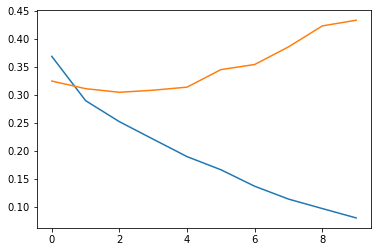

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

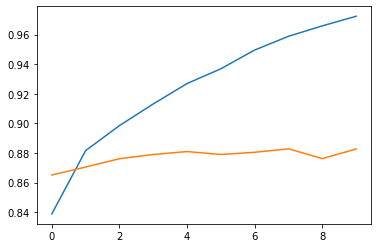

In [22]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

# Get embedding vectors

In [21]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 64)


In [23]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()